# Машинное обучение, DS-поток, осень 2022
# Задание 3.3. Линейная регрессия

In [354]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Set2')
sns.set('notebook', font_scale=1.7)


from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error
from numpy import linalg as lg

import ipywidgets as widgets
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

---
## Задача 1.

Выведите итерационную формулу пересчета коэффициентов модели с помощью формулы решения через проксимальный оператор для Ridge-регрессии. Что можно сказать о влиянии параметра регуляризации?

---
## Задача 2.

Исследуем Elastic-регрессию.

**1.** Визуализируйте множество, которое ограничивает коэффициенты в Elastic-регрессии.

**2.** Выведите итерационную формулу пересчета коэффициентов модели с помощью формулы решения через проксимальный оператор.

Какой вы можете видеть эффект при изменении параметра регуляризации и в чем
его отличие от лассо-регрессии?

**3.** Выпишите формулы для градиентного и стохастического спуска

---
## Задача 3.

Вам предлагается сравнить свойства линейных регрессионных моделей: обычной и с регуляризациями &mdash; Lasso, Ridge, Elastic Net.  

При выполнении задания воспользуйтесь готовыми реализациями методов в sklearn.

Скачайте данные <a href="https://dasl.datadescription.com/datafile/cost-of-living-2018/?_sfm_cases=539+541">`cost of living 2018`</a>, в которых используйте следующие столбцы:
* `City` &mdash; город, данные для которого приводятся.
* `Cost of Living Index` &mdash; является относительным показателем цен на потребительские товары, включая продукты, рестораны, транспорт и коммунальные услуги. Cost of Living Index не включает расходы на проживание, такие как аренда или ипотека. Если город имеет индекс стоимости жизни 120, это означает, что Numbeo оценивает его на 20% дороже, чем Нью-Йорк.

* `Rent Index` &mdash; это оценка цен на аренду квартир в городе по сравнению с Нью-Йорком. Если индекс арендной платы равен 80, Numbeo оценивает, что цена аренды в этом городе в среднем на 20% меньше, чем цена в Нью-Йорке.

* `Cost of Living Plus Rent Index` &mdash; это оценка цен на потребительские товары, включая арендную плату, по сравнению с Нью-Йорком.

* `Restaurant Price Index` &mdash; сравнение цен на блюда и напитки в ресторанах и барах по сравнению с Нью-Йорк.

* `Local Purchasing Power Index` &mdash; показывает относительную покупательную способность при покупке товаров и услуг в данном городе за среднюю заработную плату в этом городе. Если внутренняя покупательная способность составляет 40, это означает, что жители этого города со средней зарплатой могут позволить себе покупать в среднем на 60% меньше товаров и услуг, чем жители Нью-Йорка со средней зарплатой по Нью-Йорку.

* `Groceries Index` &mdash; это оценка цен на продукты в городе по сравнению с Нью-Йорком. Для расчета этого раздела Number использует веса товаров в разделе "Рынки" для каждого города.

In [648]:
data = pd.read_csv('cost-of-living-2018.txt', sep='\t')
data = data[[
    'Cost of Living Index',
    'Rent Index',
    'Cost of Living Plus Rent Index',
    'Restaurant Price Index',
    'Local Purchasing Power Index',
    'Groceries Index'
]]
data.head()

,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Restaurant Price Index,Local Purchasing Power Index,Groceries Index
0,145.43,110.87,128.76,158.75,112.26,143.47
1,141.25,66.14,105.03,135.76,142.70,149.86
2,134.83,71.70,104.38,129.74,130.96,138.98
3,130.68,49.68,91.61,127.22,139.01,127.54
4,128.03,43.57,87.30,119.48,112.71,132.70


**1.** Задача заключается в построении предсказания `Groceries Index` по известным значениям остальных параметров. Разделите данные на признаки $X$ и таргет $y$.

In [649]:
X = data[data.columns[:-1]]
y = data['Groceries Index']

Разбейте данные на обучающую и тестирующие выборки в соотношении 7:3 с помощью `train_test_split`</a> из sklearn. Далее везде вплоть до сравнения моделей используйте обучающую выборку.

In [650]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Методы с регуляризацией требуют страндартизации признаков. Поясните, почему это необходимо.

**Ответ:** *Регуляризация накладывает ограничения на размер коэффициентов, связанных с каждой переменной. Однако это значение будет зависеть от величины каждой переменной. Поэтому необходимо центрировать стандартизировать переменные, чтобы коэффициент регуляризации был оптимальным*.

Примените стандартизацию к обучающей и тестовой выборкам, используя класс <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler">`StandardScaler`</a>, **обученный на обучающей выборке**.

In [651]:
scaler = StandardScaler()
scaler.fit(X_train, y_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

**2.** Исследуйте зависимость значений коэффициентов от параметра регуляризации `alpha` для Ridge, Lasso, Elastic регрессий. Для Elastic также исследуйте зависимость от параметра `l1_ratio`. Нарисуйте графики, используя код с семинара. Предложите диапазоны значений, где стоило бы искать оптимальные параметры регуляризации.

In [652]:
def linear_predictor(alpha, model, count_of_objects=30):
    """Данная функция строит график предсказаний модели 
    на первых count_of_objects объектах датасета.
    
    :param alpha: коэффициент регуляризации
    :param model: тип модели
    """

    if model == 'Ridge':
        model = Ridge(alpha=alpha, max_iter=1000)
    elif model == 'Lasso':
        model = Lasso(alpha=alpha, max_iter=1000)
    elif model == 'Elastic':
        model = ElasticNet(alpha=alpha, max_iter=1000)

    model.fit(X_train_std, y_train)
    y_pred = model.predict(X_test_std)

    plt.figure(figsize=(14, 5))

    plt.scatter(np.arange(count_of_objects), y_pred[:count_of_objects], 
              color='#0066FF', label='Предсказания модели')
    plt.plot(np.arange(count_of_objects), y_pred[:count_of_objects], 
          color='#0066FF')
    plt.scatter(np.arange(count_of_objects), y[:count_of_objects], 
                color='#FF3300', label='Истинные значения')

    plt.grid(ls=':')
    plt.xlabel('Номер объекта', fontsize=19)
    plt.xticks(np.arange(count_of_objects))
    plt.ylabel('Предсказание', fontsize=19)
    plt.title('Предсказания {} на {} объектах'.format(model, count_of_objects), 
              fontsize=22)
    plt.legend(fontsize=19)
    plt.show() 

In [653]:
ip = widgets.interactive(
    linear_predictor, 
    alpha=widgets.FloatSlider(min=1e-6, max=10, step=1e-3, value=1),    
    model='Ridge'
);

display(widgets.HBox(ip.children[:1]))

display(ip.children[-1])
ip.update()

Output()

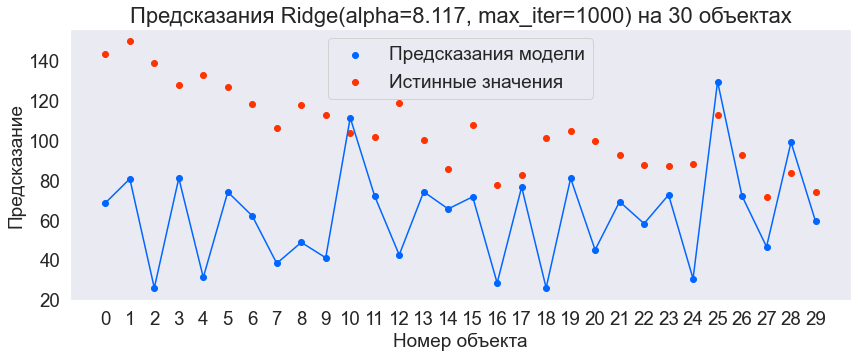

*Сразу заметим, что так как данные стандартизированы, они отличаются от таргета порядком, но таргеты стандартизировать не обязательно (это никак не влияет на результат предсказания). Поэтому пришлось сразу рассмотреть большие значения `alpha`.*

In [654]:
ip = widgets.interactive(
    linear_predictor, 
    alpha=widgets.FloatSlider(min=1e-6, max=10, step=1e-2, value=0.1),
    model="Lasso"
);

display(widgets.HBox(ip.children[:1]))

display(ip.children[-1])
ip.update()

Output()

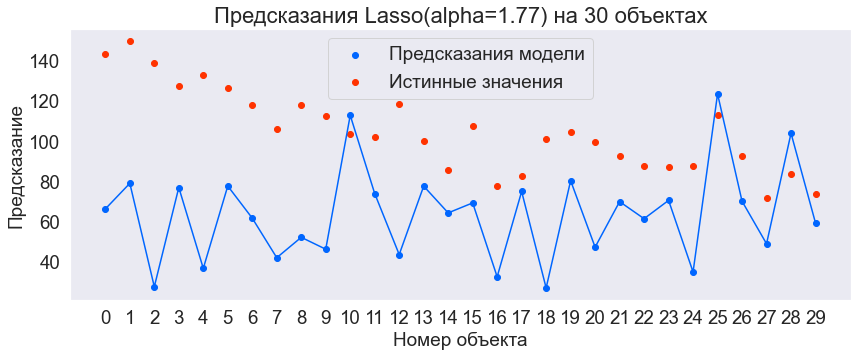

In [655]:
ip = widgets.interactive(
    linear_predictor, 
    alpha=widgets.FloatSlider(min=1e-6, max=10, step=1e-2, value=0.1),
    model="Elastic"
);

display(widgets.HBox(ip.children[:1]))
display(ip.children[-1])
ip.update()

Output()

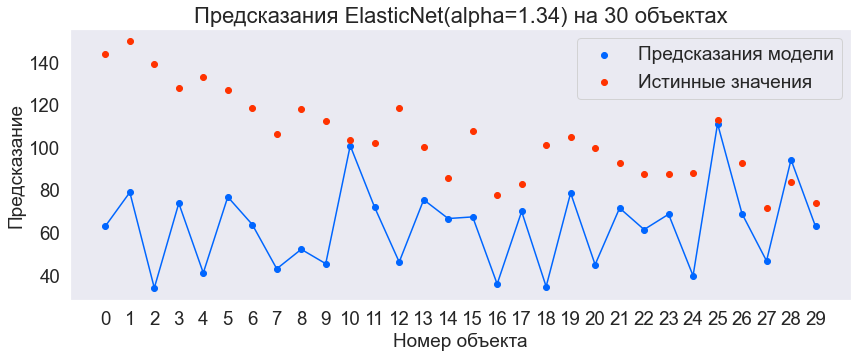

In [658]:
def linear_predictor_elastic(l1_ratio, count_of_objects=30):
    model = ElasticNet(alpha=1, l1_ratio=l1_ratio, max_iter=1000)

    model.fit(X_train_std, y_train)
    y_pred = model.predict(X_train_std)

    plt.figure(figsize=(14, 5))

    plt.scatter(np.arange(count_of_objects), y_pred[:count_of_objects], 
              color='#0066FF', label='Предсказания модели')
    plt.plot(np.arange(count_of_objects), y_pred[:count_of_objects], 
          color='#0066FF')
    plt.scatter(np.arange(count_of_objects), y[:count_of_objects], 
                color='#FF3300', label='Истинные значения')

    plt.grid(ls=':')
    plt.xlabel('Номер объекта', fontsize=19)
    plt.xticks(np.arange(count_of_objects))
    plt.ylabel('Предсказание', fontsize=19)
    plt.title('Предсказания {} на {} объектах'.format(model, count_of_objects), 
              fontsize=22)
    plt.legend(fontsize=19)
    plt.show() 

In [659]:
ip = widgets.interactive(
    linear_predictor_elastic, 
    l1_ratio=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.1)
);

display(widgets.HBox(ip.children[:1]))
display(ip.children[-1])
ip.update()

Output()

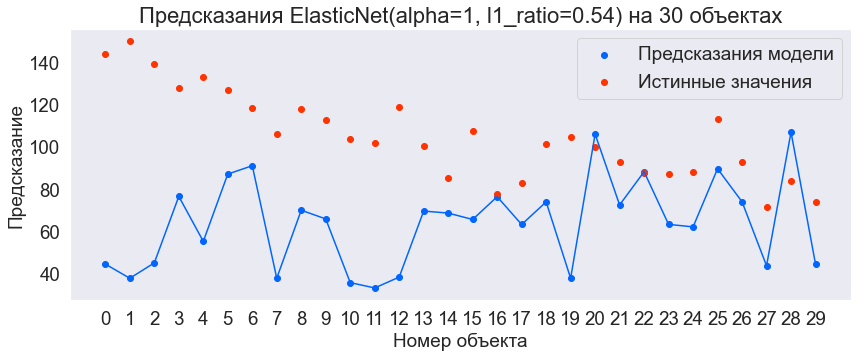

*Основываясь на Lasso и Elastic, будем искать `alpha` в диапазоне 1-5 и `l1_ratio` 0.5-0.6. Заметим, что в Ridge регрессии `alpha` получился выше, но это не противоречит результатам, так как в Ridge только l2-регуляризация, а в 2х других случаях - либо l2, либо и l1 и l2, а значит результаты могут быть разные. Логично выбрать диапазон, который близок в 2х из 3х случаев.*

In [384]:
def draw_track(model, X, y, log_min, log_max, 
               num, title='', figsize=(12, 6)):
    """
    Данная функция строит график зависимости значений 
    коэффициентов модели от параметра регуляризации
    """
    
    alphas = np.logspace(log_min, log_max, num)   
    coefs = []
    for a in alphas:
        if 'l1_ratio' in model.get_params():
            model.set_params(alpha=a, l1_ratio=0.5)
        else:
            model.set_params(alpha=a)
        model.fit(X, y)
        coefs.append(model.coef_)

    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.hlines(0, 10 ** log_min, 10 ** log_max, linewidth=15, alpha=0.15)
    ind = 1
    for coef in np.array(coefs).T:
        label = r'$\theta_{' + str(ind) + '}$'
        ax.plot(alphas, coef, linewidth=2, label=label)
        ind += 1
        
    ax.set_xscale('log')
    plt.xlabel('Параметр регуляризации', fontsize=19)
    plt.ylabel('Значения коэффициентов', fontsize=19)
    plt.title(title, fontsize=22)
    plt.legend(loc='upper left', fontsize=15)
    plt.axis('tight')
    plt.show()

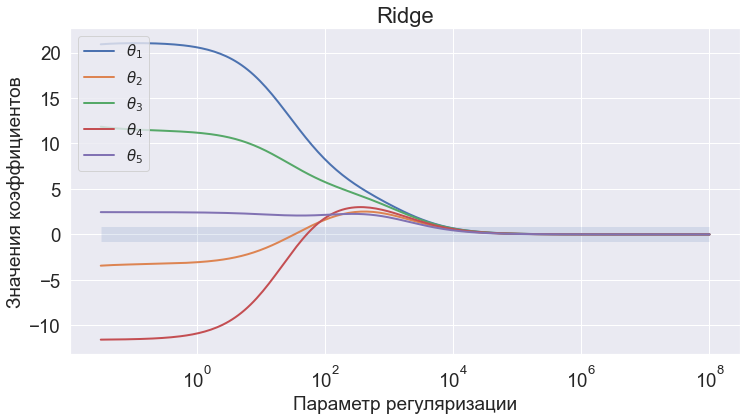

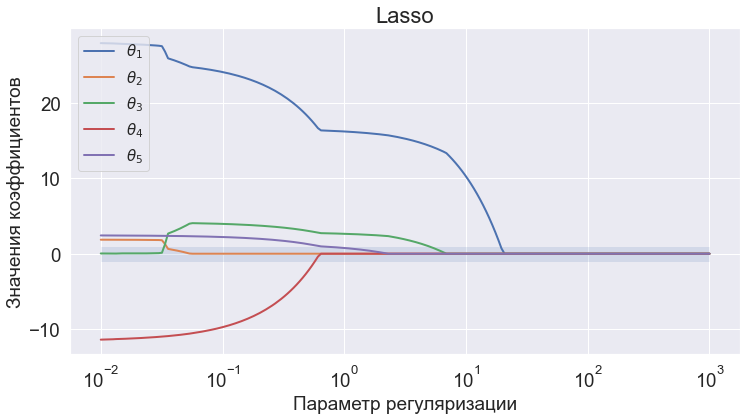

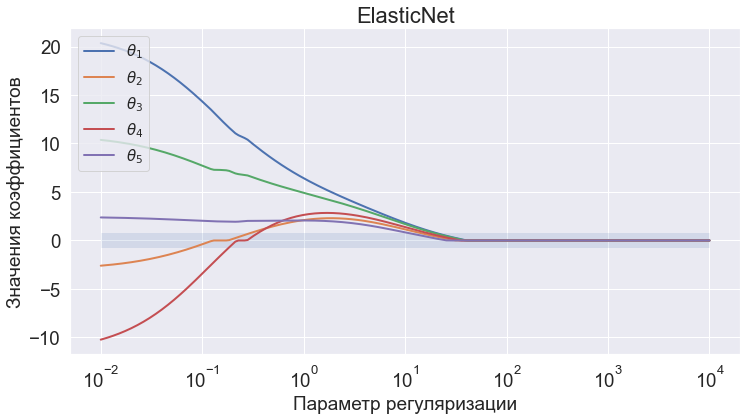

In [385]:
draw_track(Ridge(), X_train_std, y_train, 
           -1.5, 8, 200, title='Ridge')
draw_track(Lasso(), X_train_std, y_train, 
           -2, 3, 200, title='Lasso')
draw_track(ElasticNet(l1_ratio=0.5), X_train_std, y_train, 
           -2, 4, 200, title='ElasticNet')

*Чем выше значенияе коэф-та регуляризации, тем хуже учатся все три модели. Однако, у Lasso есть особенность: она до определенных значений (не слишком высоких) коэф-та регуляризации зануляет те признакм, которые не нужны, это видно по графику: зануление происходит отдельно и резко для каждого признака, в то время как в остальных двух регрессиях это происходит плавно и почти одновременно.*

Расчитайте индекс обусловленности для МНК-решения. Можно ли сделать вывод о мультиколлинеарности данных?  
Нарисуйте график зависимость индекса обусловленности от параметра регуляризации для Ridge-регрессии. 

*По формуле с лекции:*

In [386]:
eigenvalues = lg.eigvals(X_train_std.T.dot(X_train_std))

np.sqrt(eigenvalues.max() / eigenvalues.min())

13000.164521850904

*Число обусловленности матрицы:(https://numpy.org/doc/stable/reference/generated/numpy.linalg.cond.html)*

In [387]:
np.sqrt(lg.cond(X_train_std.T.dotb(X_train_std)))

13000.164549773115

*Значение так же очень большое (>> 30). Значит в данных присуствует мультиколлинеарность*

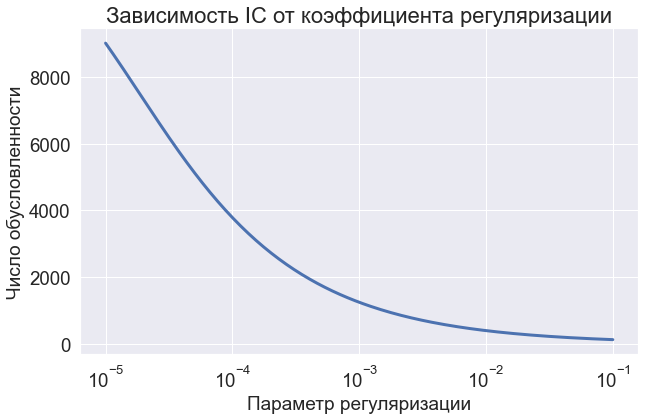

In [427]:
alphas = np.logspace(-5, -1, 200)   
plt.figure(figsize=(10,6))
ax = plt.gca()

ci_list = []
for alpha in alphas:
    ci_list += [np.sqrt(lg.cond(X_train_std.T.dot(X_train_std) + alpha*np.eye(X_train_std.shape[1])))]

ax.set_xscale('log')
plt.plot(alphas, ci_list, linewidth=3)
plt.xlabel('Параметр регуляризации', fontsize=19)
plt.ylabel('Число обусловленности', fontsize=19)
plt.title('Зависимость IC от коэффициента регуляризации', fontsize=22)
plt.axis('tight')
plt.show()

In [426]:
ridge_alphas[np.argmax(ci_list)]

1000.0

*По графику видно, что чем больше параметр регуляризации, тем меньше индекс обусловленности.*

**3.** На обучающей выборке с помощью поиска по сетке определите наилучшие параметры для Ridge, Lasso, Elastic моделей. В качестве метрики качества используйте среднеквадратичную ошибку (MSE).

*Замечание.* Не забудьте, что при стандартизации была использована вся обучающая выборка, а внутри кросс-валидации на каждой итерации рассматривается своя валидационная выборка, которая не должна стандартизироваться по данным, посчитанным частично на ней самой. Вам может помочь [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). Используйте его в качестве аргумента model

In [660]:
parameters_grid = {
    'rr__alpha' : np.linspace(0, 60*10**3, num=1000),
}

# задаем стратегию кросс-валидации
ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

# задаем модель
model = Pipeline([
    ('sc', StandardScaler()),
    ('rr', Ridge())
])

gs = GridSearchCV(
    estimator=model,
    param_grid=parameters_grid,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=ss,
)

In [661]:
gs.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.25, train_size=None),
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('rr', Ridge())]),
             n_jobs=-1,
             param_grid={'rr__alpha': array([    0.        ,    60.06006006,   120.12012012,   180.18018018,
         240.24024024,   300.3003003 ,   360.36036036,   420.42042042,
         480.48048048,   540.54054054,   600.6006006 ,   660.66066066,
         720.72072072...
       58618.61861862, 58678.67867868, 58738.73873874, 58798.7987988 ,
       58858.85885886, 58918.91891892, 58978.97897898, 59039.03903904,
       59099.0990991 , 59159.15915916, 59219.21921922, 59279.27927928,
       59339.33933934, 59399.3993994 , 59459.45945946, 59519.51951952,
       59579.57957958, 59639.63963964, 59699.6996997 , 59759.75975976,
       59819.81981982, 59879.87987988, 59939.93993994, 60000.        ])},
             scoring='neg_mean_squared_error')

In [662]:
results_ridge = gs.cv_results_
pd.DataFrame(results_ridge).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rr__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009545,0.000944,0.003554,0.003091,0.0,{'rr__alpha': 0.0},-42.884668,-30.851533,-30.111212,-35.202663,-37.046694,-35.219354,4.631791,1
1,0.006138,0.002843,0.001860,0.001656,60.06006,{'rr__alpha': 60.06006006006006},-71.013783,-45.809572,-59.192939,-100.071533,-58.517347,-66.921035,18.394267,2
2,0.003067,0.000844,0.000983,0.000200,120.12012,{'rr__alpha': 120.12012012012012},-83.722165,-53.524828,-69.739777,-113.151981,-71.251145,-78.277979,19.903924,3
3,0.003345,0.000878,0.001123,0.000493,180.18018,{'rr__alpha': 180.18018018018017},-93.199729,-59.433464,-77.075773,-120.329307,-81.493623,-86.306379,20.177206,4
4,0.002528,0.000134,0.000908,0.000041,240.24024,{'rr__alpha': 240.24024024024024},-101.775752,-64.957999,-83.645856,-126.133045,-90.927645,-93.488059,20.257196,5


*Получилось, что 0 - оптимальный параметр. Попробуем сузить сетку ближе к 0*

In [663]:
parameters_grid = {
    'rr__alpha' : np.linspace(1e-6, 0.1, num=1000),
}
gs = GridSearchCV(
    estimator=model,
    param_grid=parameters_grid,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=ss,
)
gs.fit(X_train, y_train)
results_ridge = gs.cv_results_

In [664]:
gs.best_estimator_

Pipeline(steps=[('sc', StandardScaler()),
                ('rr', Ridge(alpha=0.000901891891891892))])

*Видим, что результат grid search для Ridge-регрессии не не совпал с визуальным подбором параметра.*

*Аналогично попробовав несколько разных интервалов для 2х других регрессий, начиная с указанных в пред пункте, я сузила их для до тех что ниже на основании MSE (mean_test_score)*

In [665]:
parameters_grid_lasso = {
    'lr__alpha' : np.linspace(1e-9, 1e-2, num=1000),
}

# задаем модель
model_lasso = Pipeline([
    ('sc', StandardScaler()),
    ('lr', Lasso())
])

gs_lasso = GridSearchCV(
    estimator=model_lasso,
    param_grid=parameters_grid_lasso,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=ss
)

In [666]:
gs_lasso.fit(X_train, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.25, train_size=None),
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('lr', Lasso())]),
             n_jobs=-1,
             param_grid={'lr__alpha': array([1.00000000e-09, 1.00110090e-05, 2.00210180e-05, 3.00310270e-05,
       4.00410360e-05, 5.00510450e-05, 6.00610541e-05, 7.00710631e-05,
       8.00810721e-05, 9.00910811e-05, 1.001...
       9.76976979e-03, 9.77977980e-03, 9.78978981e-03, 9.79979982e-03,
       9.80980983e-03, 9.81981984e-03, 9.82982985e-03, 9.83983986e-03,
       9.84984986e-03, 9.85985987e-03, 9.86986988e-03, 9.87987989e-03,
       9.88988990e-03, 9.89989991e-03, 9.90990992e-03, 9.91991993e-03,
       9.92992994e-03, 9.93993995e-03, 9.94994995e-03, 9.95995996e-03,
       9.96996997e-03, 9.97997998e-03, 9.98998999e-03, 1.00000000e-02])},
             scoring='neg_mean_squared_error')

In [667]:
gs_lasso.best_estimator_

Pipeline(steps=[('sc', StandardScaler()),
                ('lr', Lasso(alpha=1.0011009009009011e-05))])

In [668]:
parameters_grid_es = {
    'er__alpha' : np.linspace(1e-6, 1, num=1000),
    'er__l1_ratio': np.linspace(0, 1, num=10)
}

# задаем модель
model_es = Pipeline([
    ('sc', StandardScaler()),
    ('er', ElasticNet())
])

gs_es = GridSearchCV(
    estimator=model_es,
    param_grid=parameters_grid_es,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=ss
)

In [ ]:
gs_es.fit(X_train, y_train)

На тестовой части данных сравните качество моделей с оптимальными параметрами. Какая модель дала лучший результат?

In [670]:
y_pred_ridge = gs.best_estimator_.predict(X_test)
y_pred_lasso = gs_lasso.best_estimator_.predict(X_test)
y_pred_es = gs_es.best_estimator_.predict(X_test)

print('MSE Ridge', np.round(mean_squared_error(y_pred_ridge, y_test), 2))
print('MSE Lasso', np.round(mean_squared_error(y_pred_lasso, y_test), 2))
print('MSE Elastic', np.round(mean_squared_error(y_pred_es, y_test), 2))

MSE Ridge 33.48
MSE Lasso 33.47
MSE Elastic 33.47


*Лучший результат дает Ridge и Elastic. Это ожидаемо, потому что пространство поиска для Elastic является надмножеством пространства поиска для Lasso и Ridge.*

In [671]:
model_ls = LinearRegression().fit(X_train_std, y_train)
y_pred_ls = model_ls.predict(X_test_std)

print('MSE Least Squares', round(mean_squared_error(y_pred_ls, y_test), 3))

MSE Least Squares 33.754


**4.** Сделайте общий вывод по задаче.

**Вывод:** *Визуально были подобраны оптимальные значения параметров `alpha`, но они не совпали с теми что были найдены через grid search, поэтому важно проводить grid search для подбора оптимальных параметров. Так же, во всех 3х случаях оптимальные параметры оказались очень близкими к 0. Это может означать, что для регрессии на этих данных регуляризация не нужна, так как в результате сравнения моделей с МНК получилось, что у МНК MSE совсем немного ниже, чем у Ridge и Lasso*.
*Также исследование показало, что регуляризация является хорошим способом борьбы с мультиколлинеарностью.*

## Задача 4.

В этой задаче вам предлагается реализовать регрессию Хьюбера, а также применить ее к данным с выбросами. Для начала реализуйте класс по шаблону снизу. Обратите внимание, что класс `HuberRegression` &mdash; наследник класса `BaseEstimator`, это с легкостью позволит использовать наш класс, например, в `GridSearchCV`.

**1.** Задача оптимизации для регрессии Хьбера выглядит следующим образом:
$$\large{\sum_{i=1}^n R(Y_i - x_i^T\theta) \rightarrow \min_\theta},$$
где $R(x) = \frac{x^2}{2} I\{|x| < c\} + c (|x| - \frac{c}{2})I\{|x| > c\},$ &mdash; функция потерь Хьюбера.

Выпишите формулы для градиентного и стохастического градиентного спусков. В чем польза такой функции потерь?

*Польза от такой функции потерь: значение квадратично для малых отклонений, и линейно для больших, то есть модель чувствительнее к значениям, близким к истинному значению, и менее - к выбросам. Поэтому преимущество функции потерь Хьюбера в том, что она не сильно зависит от выбросов, но при этом не полностью игнорирует их влияние.*

**2.** Реализуем теперь класс

In [594]:
class HuberRegression(BaseEstimator):
    '''
    Класс, реализующий линейную регрессию, используя функцию потерь Хьюбера.
    '''
    
    def __init__(self, c=1, fit_intercept=True, max_iter=500, batch_size=64):
        '''
        :param c: константа c из определения функции потерь Хьюбера
        :param fit_intercept: добавлять ли константный признак
        :param max_iter: макс. количество итераций процедуры оптимизации
        '''
        
        self.c = c
        self.fit_intercept = fit_intercept
        self.max_iter = max_iter
        self.lr = 0.01
        self.batch_size = batch_size


    def fit(self, X, y):
        '''
        Функция обучения модели.
        
        :param X: матрица признаков
        :param y: значения целевой паременной
        '''
        
        train_size, num_features = X.shape
        # Добавим к признакам смещение
        if self.fit_intercept:
            X = np.concatenate((np.ones((train_size, 1)), X), axis=1)
            num_features += 1
            
        # Начальное приближение в начале координат
        self.theta = np.zeros(num_features)
        
        for _ in range(self.max_iter):
            # Генерируем mini-batch
            indices = np.random.choice(X.shape[0], self.batch_size)
            x_mbatch = X[indices, :]
            y_mbatch = y[indices]
            
            # индексы тех, у кого абс. смещение небольшое
            less_c_indices = np.abs(
                y_mbatch - x_mbatch @ self.theta) < self.c
            grad = np.zeros_like(self.theta)
            # считаем градиент, учитывая два случая
            grad += x_mbatch[less_c_indices, :].T @ (
                y_mbatch[less_c_indices] - \
                x_mbatch[less_c_indices, :] @ self.theta
            )
            grad += self.c * x_mbatch[~less_c_indices, :].T @ np.sign(
                y_mbatch[~less_c_indices] - \
                x_mbatch[~less_c_indices, :] @ self.theta
            )
            # обновляем параметры
            self.theta += self.lr * grad * (X.shape[0] / self.batch_size)
            
        return self
        
    def predict(self, X):
        '''
        Функция применения модели.
        
        :param X: матрица признаков.
        :return pred: предсказание отклика для объектов из X
        '''
        
        if self.fit_intercept:
            X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
            
        return X.dot(self.theta)

**3.** Загрузите данные из файлов `train.csv`, `test.csv`. Не забудьте, что всю аналитику, а также процесс обучения и подбор гиперпараметров необходимо выполнять на обучающей выборке.

In [576]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

X_train, y_train = data_train[data_train.columns[:-1]], data_train['target']
X_test, y_test = data_test[data_test.columns[:-1]], data_test['target']

Посмотрите на зависимость целевой переменной от каждого признака. Что можно сказать о наличии возможных выбросов? Какое влияние они могут оказать? 

In [564]:
data_train.corr()

,feature_1,feature_2,feature_3,target
feature_1,1.000000,0.382419,0.414948,-0.303620
feature_2,0.382419,1.000000,0.438471,-0.253630
feature_3,0.414948,0.438471,1.000000,-0.282473
target,-0.303620,-0.253630,-0.282473,1.000000


*Таргет имеет примерно одинаковую несильную линейную зависимость с каждым признаком, больше всего - с первым*

<Figure size 1800x1080 with 0 Axes>

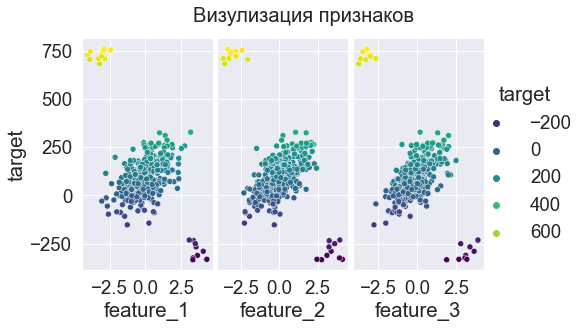

In [642]:
g = sns.pairplot(data=data_train, x_vars=data_train.columns[:-1], y_vars=['target'], palette='viridis', hue='target')
g.fig.set_size_inches(8, 5)
g.fig.suptitle('Визулизация признаков', y=1.05, fontsize=20);

*Хорошо заметны выбросы по всем трем признакам (2 небольших кластера по краям), причем это почти одни и те же значения*

**2.** Обучите простую линейную регрессию и посчитайте качество на тестовой выборке по метрике [MSE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error). Что можно сказать о качестве нашей модели?

In [566]:
reg_ls = LinearRegression()
reg_ls.fit(X_train, y_train)
y_pred_ls = reg_ls.predict(X_test)

print('Least squares MSE: ', round(mean_squared_error(y_pred_ls, y_test), 3))

Least squares MSE:  17025.807


**3.** Теперь обучите линейную регресcию Хьюбера и посчитайте качество на тестовой части по метрикe MSE. Что изменилось? 

In [586]:
reg_huber = HuberRegression(c=10)
reg_huber.fit(X_train, y_train)
y_pred_huber = reg_huber.predict(X_test)

print('Huber MSE: ', round(mean_squared_error(y_pred_huber, y_test), 3))

Huber MSE:  101.674


*MSE снизилось, но порядок ошибки все ещё большой, по этой метрике качество модели низкое*

**4.** Используя поиск по сетке, подберите оптимальное значение гиперпараметра $c$ нашей модели. Какую метрику стоит использовать? Почему?

*Нужно использовать метрику MAPE, так как такие метрики как MSE и R2 будут склонять процедуру в сторону выбора тех параметров, которые больше могут выучить выбросы*

In [615]:
parameters_grid_hub = {
    'c' : np.linspace(0.001, 20, num=1000),
}

gs_hub = GridSearchCV(
    estimator=HuberRegression(),
    param_grid=parameters_grid_hub,
    scoring='neg_mean_absolute_percentage_error',
    cv=ss
)
gs_hub.fit(X_train.values, y_train.values)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.25, train_size=None),
             estimator=HuberRegression(),
             param_grid={'c': array([1.00000000e-03, 2.10190190e-02, 4.10380380e-02, 6.10570571e-02,
       8.10760761e-02, 1.01095095e-01, 1.21114114e-01, 1.41133133e-01,
       1.61152152e-01, 1.81171171e-01, 2.01190190e-01, 2.21209209e-01,
       2.41228228e-01, 2.61247247e-01, 2....
       1.95395626e+01, 1.95595816e+01, 1.95796006e+01, 1.95996196e+01,
       1.96196386e+01, 1.96396577e+01, 1.96596767e+01, 1.96796957e+01,
       1.96997147e+01, 1.97197337e+01, 1.97397528e+01, 1.97597718e+01,
       1.97797908e+01, 1.97998098e+01, 1.98198288e+01, 1.98398478e+01,
       1.98598669e+01, 1.98798859e+01, 1.98999049e+01, 1.99199239e+01,
       1.99399429e+01, 1.99599620e+01, 1.99799810e+01, 2.00000000e+01])},
             scoring='neg_mean_absolute_percentage_error')

In [621]:
print('MSE Huber, best estimator: ', round(mean_squared_error(gs_hub.best_estimator_.predict(X_test), y_test), 3))

MSE Huber, best estimator:  52.938


*Отлично, значение ошибки снизилось еще больше*

**5.** Для обучающей выборки постройте два графика (по графику на каждую модель), на которых изобразите зависимость истинного и предсказанного значения таргета от каждого признака. Что можно заметить на этих графиках?

In [634]:
y_pred_huber = gs_hub.best_estimator_.predict(X_train)
y_pred_ls = reg_ls.predict(X_train)

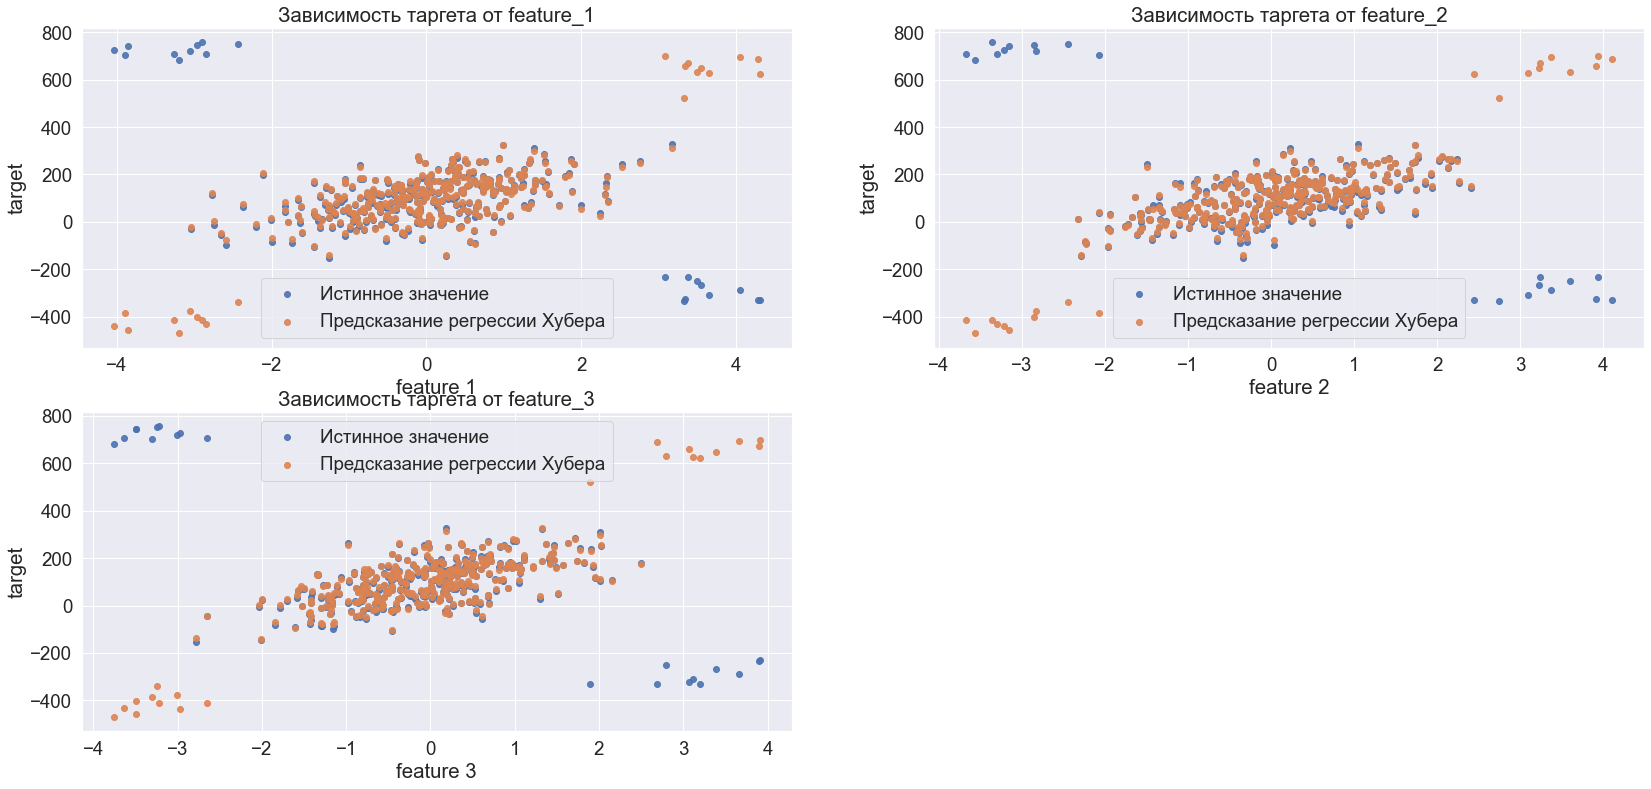

In [647]:
plt.figure(figsize=(28, 20))

for i in range(3):
    plt.subplot(3, 2, i+1)
    plt.scatter(X_train.iloc[:, i], y_train, 
                alpha=0.9, label='Истинное значение')
    plt.scatter(X_train.iloc[:, i], y_pred_huber, 
                alpha=0.9, label='Предсказание регрессии Хубера')
    
    plt.title(f'Зависимость таргета от feature_{i + 1}')
    plt.xlabel(f'feature {i + 1}')
    plt.ylabel('target')
    plt.legend()

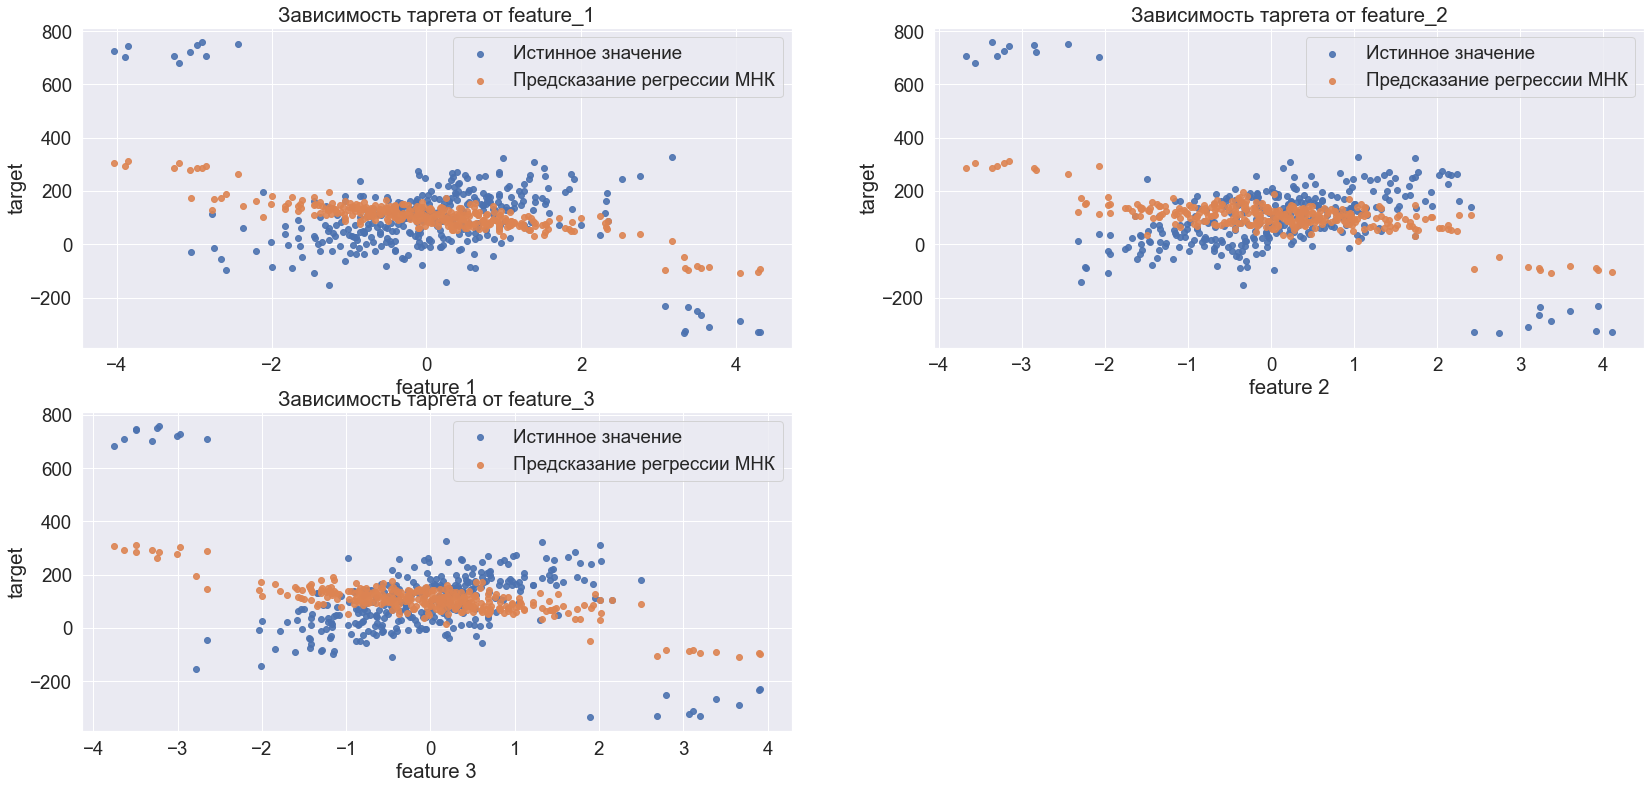

In [646]:
plt.figure(figsize=(28, 20))

for i in range(3):
    plt.subplot(3, 2, i+1)
    plt.scatter(X_train.iloc[:, i], y_train, 
                alpha=0.9, label='Истинное значение')
    plt.scatter(X_train.iloc[:, i], y_pred_ls, 
                alpha=0.9, label='Предсказание регрессии МНК')
    
    plt.title(f'Зависимость таргета от feature_{i + 1}')
    plt.xlabel(f'feature {i + 1}')
    plt.ylabel('target')
    plt.legend()

*Регрессия Хубера, в отличие от простого МНК, хорошо адаптировалась под выбросы и аппроксимировала реальные зависимости. На графиках хорошо видно, как предсказания МНК сильно сдвинулись из-за влияния шума.*

**Вывод:** *Регрессия Хубера лучше чем простая регрессия умеет работать с датасетами с шумом. Также в задаче был дан датасет с линейно-зависимыми признаками, и мы получили, что регрессия Хубера дала лучшее качество чем простой МНК.*